# 6: Design the Product Level Similarity Score

In this notebook, we are going to design the algorithm for the Product Level Similariy Score

This is part of the ranking algorithm design.....

In [1]:
# install the faiss-cpu when new env is provisioned
#!pip install faiss-cpu
#conda install -c pytorch faiss-cpu=1.7.4 mkl=2021

In [2]:
# install the openai when new env is provisioned
#!pip install openai

#conda install -c conda-forge openai

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import umap
import faiss
import openai
import pandas as pd
import numpy as np
import altair as alt
import configparser
from PIL import Image


## Prepare required resources

In [4]:
df_apparel = pd.read_csv('../resources/data/apparel_15to25.tsv.gz', sep='\t', compression='gzip')
cols = ['product_id', 'review_id', 'star_rating', 'product_title', 'review_body']
df_apparel = df_apparel[cols]
df_apparel.head(3)

,product_id,review_id,star_rating,product_title,review_body
0,245600258X,RZER3NRRB523C,4.0,La Leela Hawaiian Shirt For Men Short Sleeve F...,Quickly tore on one side. A very nice and com...
1,245600258X,RDNDYIC6MH3Q5,4.0,La Leela Hawaiian Shirt For Men Short Sleeve F...,One size smaller would have been fine. I had ...
2,245600258X,R1Z0YOWJGWESSD,5.0,La Leela Hawaiian Shirt For Men Short Sleeve F...,"Great Hawaiian shirt. Very comfortable, loose..."


In [5]:
# Load the pre-created FAISS index
faiss_index = faiss.read_index('../resources/binary/apparel_15to25_review_cosine.faissindex')

In [6]:
# Load your API key from an environment variable or secret management service
config = configparser.ConfigParser()
config.read('nes.ini')
openai.api_key = config['OpenAI']['api_key']

## Define helper functions

In [7]:
# Helper function to create the query embedding. Make sure to use the same model as what we used to created the product embedding
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   
   return np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'], dtype='float32').reshape(1, -1)

In [8]:
def search_with_original_query(df, faiss_index, query_embedding, num_of_records=100):
    # we need to normalize the question embedding in order to use cosine similarity to search 
    faiss.normalize_L2(query_embedding)

    # distance is the correspnding distance
    # result_idx is the index of the input array, hence the index of the dataframe (if the dataframe index is reset which starts with 0)
    distance, result_idx = faiss_index.search(query_embedding, k=num_of_records)

    # use the return index to create the result dataframe
    df_result = df.iloc[result_idx.squeeze().tolist()]
    # add Distance to the result dataframe
    df_result['distance'] = distance.T

    df_result = df_result.sort_values(by='distance', ascending=True)
    
    return df_result, result_idx

In [9]:
def generate_opposite_query(orignal_query='', prompt=''):

    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt.format(orignal_query),
        temperature=0,
        max_tokens=1000,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0
    )

    return response['choices'][0]['text']

In [10]:
def search_with_opposite_query(df, faiss_index, opposite_query_embedding, original_query_result_index, num_of_records=100):

    faiss.normalize_L2(opposite_query_embedding)

    # we want to make sure the opposite query only compare against the texts found by the original query 
    id_selector = faiss.IDSelectorArray(original_query_result_index.shape[1], faiss.swig_ptr(original_query_result_index))
    filtered_distances, filtered_indices = faiss_index.search(opposite_query_embedding, k=num_of_records, params=faiss.SearchParametersIVF(sel=id_selector))

    df_opposite_result = df.iloc[filtered_indices.squeeze().tolist()]
    df_opposite_result['distance'] = filtered_distances.T

    df_opposite_result = df_opposite_result.sort_values(by='distance', ascending=False)

    return df_opposite_result

In [11]:
def get_reconcile_result(df_result_original, df_result_opposite):

    df_reconcile_result = df_result_original.merge(df_result_opposite[['review_id', 'distance']], 
                            left_on='review_id', right_on='review_id', how='left', suffixes=('_original', '_opposite'))
    
    # Using Dot Product FAISS Index with L2 normaliztion, the returning result is Cosine Similiarty, rather than Distance.
    # There will turn the Cosine Similarity to Distance 
    df_reconcile_result['distance_original'] = 1 - df_reconcile_result['distance_original']
    df_reconcile_result['distance_opposite'] = 1 - df_reconcile_result['distance_opposite']

    df_reconcile_result = df_reconcile_result.sort_values(by='distance_original', ascending=True).reset_index(drop=True)

    return df_reconcile_result

In [12]:
# Helper function to clip the distance_opposite

def clip_distance_opposite(df, clipping=0.5):
    df = df.sort_values(by='distance_opposite', ascending=False).reset_index(drop=True)
    # Flatten the first n% with distance_opposite sorted in descending order  
    quantile_value = df['distance_opposite'].quantile(q=(1-clipping))
    df.loc[0:(clipping * len(df)), ['distance_opposite']] = quantile_value

    return df

In [13]:
# Helper function to calculate adjsuted distance using the distance_oppsite as a penalty term

def cal_adjusted_distance(df, k=0.5):
    df['distance_adjusted'] = df.apply(lambda row: row['distance_original'] + (k * 1/row['distance_opposite']), axis='columns')
    
    return df 

In [14]:
# Helper function to calculate review level similarity scores

def cal_review_similarity_score(df):
    # find max of distance_adjusted  
    max_distance_adjusted  = df['distance_adjusted'].max()
    # normalized adjusted distance then subtract from 1 to calculate the similarity score 
    df['similarity_score'] = df['distance_adjusted'].apply(lambda x: 1 - x / max_distance_adjusted)

    return df 

In [15]:
# Helper function to calculate the product level similarity scores 

def cal_product_similarity_score(df, method='discount_reward'):

    if method == 'average':
        df_temp = df.groupby('product_id')['similarity_score'].mean()
        df_temp = df_temp.to_frame(name='product_similarity_score').reset_index()
        df = pd.merge(df, df_temp, left_on='product_id', right_on='product_id')
    else:
        df_grouped = df.groupby(by='product_id')

        for name, data in df_grouped:
            data = data.sort_values('similarity_score', ascending=False)
            scores = []
            for cnt, (index, row) in enumerate(data.iterrows()):
                discounted_score = row['similarity_score'] / pow(2, cnt)
                scores.append(discounted_score)
            df.loc[data.index, 'product_similarity_score'] = sum(scores)
        
    df = df.sort_values(by=['product_similarity_score', 'similarity_score'], ascending=[False, False])

    return df

In [16]:
def plot_distances(df_input, title=''):
    df = df_input.copy()
    df = df[['distance_original', 'distance_opposite']]
    df['distance_original'] = df['distance_original'].astype('float64')
    df['distance_opposite'] = df['distance_opposite'].astype('float64')
    df = df.reset_index(drop=True).reset_index()
    df.columns=['index', 'original_query', 'opposite_query']
    df = df.melt(id_vars=['index'])

    domain = ['opposite_query']
    range_ = ['coral']

    chart = alt.Chart(data=df).mark_line().encode(
            x=alt.X('index:Q').title('Record Index'),
            y=alt.Y("value:Q").scale(domain=(0,0.4)).title('Cosine Distance'),
            color=alt.Color("variable:N").scale(domain=domain, range=range_)
        ).properties(
            width=400,
            height=200,
            title=title
        )
    
    return chart

## Analysis on the Cosine Distance for for both the original query and the opposite query against the search result  

### Define the original query and get the corresponding search result

In [17]:
query = "Long thin cotton socks for men, need to be breathable, even feeling cool for summer time."
#query = "Wrinkle free chiffon blouse, sleek style, long sleeve, slim fit, with comfortable inside layer"

# create the embedding for orignal query 
query_embedding = get_embedding(query)

# search the FAISS index with orignal query embedding 
df_result_original, result_idx = search_with_original_query(df_apparel, faiss_index, query_embedding, num_of_records=100)

### Calculate the cosine distance 

In [18]:
prompt ="""
    You are an English teacher. You need to find every single ADJECTIVE from the sentences delimited by triple backquotes below.
    Then, you transform every adjective into its antonym.
    Finally, give the dictionary meaning for each antonym.
    Below are two examples. You need to comlete the third one. 
    

    Text 1: Kids flip flops for girl, cute, good fit, comfortable and durable, low price
    Output 1: Artless means without guile or deception. Unsuited means not proper or fitting for something. Uncomfortable means causing discomfort.  Fragile means easily broken. Costly means expensive.
    ## 
    Text 2: Long sleeve shirts for men. Wrinkle-free, thick but breathable and slim fit
    Output 2: Short means having little length. Crinkle means to form many short bends or ripples. Thin means measuring little in cross section or diameter. Airtight means impermeable to air or nearly so. Wide means having a greater than usual measure across
    ##
    Text 3:  ```{}```
    Output 3:
"""

In [19]:
# generate opposite query rewrite
opposite_query = generate_opposite_query(query, prompt)

# get the embedding for the opposite query 
opposite_query_embedding = get_embedding(opposite_query)

# search the FAISS index with the opposite query. We need to pass the result_idx from the orignal query in order to limit the seach scope 
df_result_opposite = search_with_opposite_query(df_apparel, faiss_index, opposite_query_embedding, result_idx, num_of_records=100)

# generate the reconsile result 
df_reconcile_result = get_reconcile_result(df_result_original, df_result_opposite)

print(f"Original Query === {query}")
print(f"Opposite Query === {opposite_query}")

Original Query === Long thin cotton socks for men, need to be breathable, even feeling cool for summer time.
Opposite Query === Short means having little length. Thick means having a greater than usual measure across. Stuffy means not allowing air to circulate freely. Hot means having a high degree of heat or a high temperature.


In [20]:
df_reconcile_result[['product_title', 'review_body', 'distance_original', 'distance_opposite']].head(10) \
    .style.set_properties(**{'text-align': 'left'}).set_properties(subset=['review_body'], **{'width': '600px'})

,product_title,review_body,distance_original,distance_opposite
0,Mens plain 100% cotton socks (Pack of 6),"These are perfect - exactly as I'd hoped. Thin, comfortable, high-quality cotton socks that don't make my feet sweat in the AZ heat. Ordering more.",0.101515,0.245009
1,Galiva Men's Cotton Lightweight Fashion Dress Socks,"Kind of thin if you are used to the fluffies, but a nice sock all round.",0.101687,0.234178
2,Calvin Klein Men's Combed Flat-Knit Socks (3-Pack),"In short, these are awesome. Thin enough and cool enough to be worn in the summer, durable and good-looking - and affordable enough I can buy another couple packs and stop playing hide-and-seek with missing socks.",0.107604,0.256174
3,Mens Dress Socks - Colorful Classic Fun (7 5 Pairs Pack) - Business and Casual,They are thin sock that keeps my foot cool with a little style.,0.110173,0.250013
4,Boot Doctor Men's Over the Calf Socks (3 Pack),"vented enough for summer wear, thin enough to add second pair of socks.",0.110207,0.245860
5,Mens plain 100% cotton socks (Pack of 6),I was a little worried when I saw that these shipped from England. No worries. My husband LOVES these socks. He was looking for thin socks because his feet overheat when wearing sneakers and being on his feet all day at his job. They are so soft and nothing like thin socks we were seeing on the store shelves here in the U.S.. I just ordered 3 more sets for him. These would also make great dress socks for a suit wearing businessman.,0.114011,0.249837
6,Fruit Of The Loom Men's 6 Pack Cushioned Crew Socks,Cotton socks fit well and comfortable. This is what I want in a cotton sock.,0.114059,0.265373
7,Men's - Women's Thin Padded Running Low-Cut Socks,"Good sock, I neglected to note the lack of cotton which I like to have for breathability. I gave these to my daughter who loves them. They have nice support and are very comfortable and durable.",0.114235,0.257491
8,Specialist item: Mens Ribbed Non Elastic Top 100% Cotton Socks (Pack of 6),"Very comfortable, thin socks. Great for sleeping/night time use on a cool night. Not constricting like some socks, so blood can circulate well.",0.114448,0.251318
9,Galiva Men's Cotton Lightweight Fashion Dress Socks,"Being a construction worker I really face days that encounters to be for long hours under the boiling sun, this triggers I should be more exposed to sweating. I had searched for years socks that will be thin yet comfortable without sweating but I never had found the ideal sock, after hearing about your wonderful black, white and grey socks I was so surprised and amazed after using this socks that THIS IS THE SOCKS that I was searching for so long! Its not just the quality that lasts, its also the fit and fine texture. I would recommend anyone to buy it, you would definable not regret your purchase.",0.114575,0.257628


In [21]:
print(opposite_query)

Short means having little length. Thick means having a greater than usual measure across. Stuffy means not allowing air to circulate freely. Hot means having a high degree of heat or a high temperature.


In [22]:
df_reconcile_result.sort_values(by='distance_opposite', ascending=False) \
    [['product_title', 'review_body', 'distance_original', 'distance_opposite']].head(5) \
    .style.set_properties(**{'text-align': 'left'}).set_properties(subset=['review_body'], **{'width': '600px'})

,product_title,review_body,distance_original,distance_opposite
70,Galiva Men's Cotton Lightweight Fashion Dress Socks,"If someone is looking for classic comfortable socks, I would recommend Galiva, I've bought them accidentally and finally I found the sock I've always looked for.",0.131178,0.285449
74,Men's Performance CoolMax® Cushioned Running Socks by Iyzer for Cool & Dry Feet,Bought these for hubby! He is big into running and he loves that they are breathable. He said they help his feet to breath which helps his running.,0.131689,0.280890
46,Calvin Klein Men's Egyptian Cotton Dress Socks,These are the only socks I've worn this past year or so. Really comfortable without excessive elastic. Very soft Egyptian cotton absorbs sweat and keeps your feet dry. That's also a slight drawback because they will wear out quicker than a blend but I'm ok with that. Price for this quality is very good.,0.127495,0.279869
57,Wrightsock Men's Coolmesh II Quarter Single Pack Socks,"If you are a runner or a cross-fitter, you will love these! Your feet will stay dry, your feet and sneakers won't smell, reduced chance of athlete's foot, and virtually eliminates blister issues. What more could you want out of a sock? Oh and comfy too!",0.129302,0.279506
56,Wrightsock Men's Coolmesh II Quarter Single Pack Socks,I love these socks. I wish they made more colors but have used them for marathons the last 10 years. Thin and double layer works for me. They wear out fairly quickly but fit and feel great.,0.129242,0.279422


In [23]:
df_reconcile_result.sort_values(by='distance_opposite', ascending=False) \
    [['product_title', 'review_body', 'distance_original', 'distance_opposite']].tail(10) \
    .style.set_properties(**{'text-align': 'left'}).set_properties(subset=['review_body'], **{'width': '700px'})

,product_title,review_body,distance_original,distance_opposite
81,Soffe Men's Classic Cotton Pocket Short,"Well designed and well made 100% cotton shorts. It's hard to be lyrical about something as prosaic as summer shorts,yet these are the best I've been able to find on line at a reasonable price . Comfortable and well styled.",0.132447,0.245765
93,Soffe Men's Classic Cotton Pocket Short,"Material feels a bit rough on the outside, but is comfortable wearing at home.",0.133169,0.245185
0,Mens plain 100% cotton socks (Pack of 6),"These are perfect - exactly as I'd hoped. Thin, comfortable, high-quality cotton socks that don't make my feet sweat in the AZ heat. Ordering more.",0.101515,0.245009
77,Champion Men's 6 Pack Crew Socks,"They fit tight, as some mentioned in their reviews. Thick enough to meet my needs. (Super skinny, long feet.)",0.131906,0.244685
49,Dickies Men's 2 Pack Steel Toe Crew Socks - Big & Tall,Perfect for winter. Socks are thick for summer. Husband loved them either way.,0.128032,0.242857
65,Wigwam Men's Merino Airlite Pro Socks,These socks are medium thickness. They feel very comfortable bit I was expecting a much thinner sock.,0.130381,0.239453
71,"Hanes Men's 10 Pack X-Temp No Show Socks, White/Red, 10-13/Shoe Size 6-12",Comfy. A little thick for a running sock (in my opinion).,0.131208,0.239133
10,MeMoi Men's Colored Tips Half Cushioned 6 Pair Low Cut Socks,These socks are a bit on the thin side. They'd be better for summer than winter.,0.115118,0.237768
69,Soffe Men's Classic Cotton Pocket Short,Good quality heavy-cotton short. Great for cooler spring & summer days either for walking or working outside. Very pleased with this purchase.,0.131138,0.236298
1,Galiva Men's Cotton Lightweight Fashion Dress Socks,"Kind of thin if you are used to the fluffies, but a nice sock all round.",0.101687,0.234178


In [24]:
df_temp = df_reconcile_result.sort_values(by='distance_opposite', ascending=False).reset_index(drop=True)

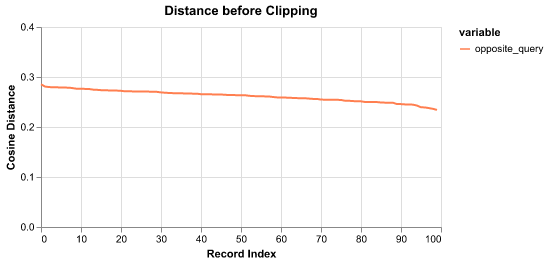

In [25]:
chart = plot_distances(df_input=df_temp, title='Distance before Clipping')
#chart.save('../resources/img/distance_before_clipping.png')
Image.open('../resources/img/distance_before_clipping.png')

We don't want to overboost those product_title + review_body that are actually not relevant to the product search 

In [26]:
df_copy = df_reconcile_result.copy()

In [27]:
df_copy = clip_distance_opposite(df_copy, clipping=0.1)

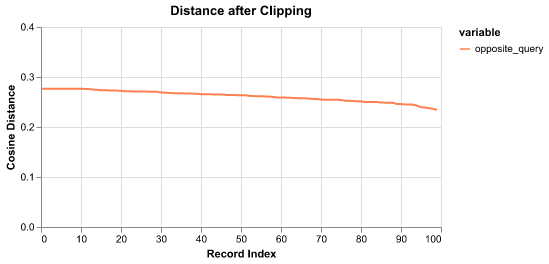

In [28]:
chart = plot_distances(df_input=df_copy, title='Distance after Clipping')
#chart.save('../resources/img/distance_after_clipping.png')
Image.open('../resources/img/distance_after_clipping.png')